In [1]:
'''
=====Experiment=====
Dataset: CIC-IDS-2017 dataset

Downsample 90% normal traffic randomly
Split train and test subgraph randomly
Training in chronological window subgraph

IP as node
Encode Ports in raw numbers
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader


project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.CIC_IDS_2017.CIC_IDS_2017_config import CIC_IDS_2017_Config

In [2]:
csv_file_name = "all_downsampled"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"CIC_IDS_2017/All/{csv_file_name}.csv"))

DATASET_NAME = "CIC_IDS_2017"
EXPERIMENT_NAME = "split_random_window_raw_port"

SOURCE_FILE_ID_COL_NAME = CIC_IDS_2017_Config.SOURCE_FILE_ID_COL_NAME

SOURCE_IP_COL_NAME = CIC_IDS_2017_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = CIC_IDS_2017_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = CIC_IDS_2017_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = CIC_IDS_2017_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = CIC_IDS_2017_Config.ATTACK_CLASS_COL_NAME

BENIGN_CLASS_NAME = CIC_IDS_2017_Config.BENIGN_CLASS_NAME

TIME_COLS = CIC_IDS_2017_Config.TIME_COL_NAMES

print(data[ATTACK_CLASS_COL_NAME].value_counts())

MULTICLASS = True

label_col = ATTACK_CLASS_COL_NAME


saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

Label
DoS Hulk                      231073
BENIGN                        227310
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Infiltration                      36
Web Attack - Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64


In [3]:
data.drop(columns=CIC_IDS_2017_Config.DROP_COLS,inplace=True)
print(data.columns)

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Min',
       'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Mean',
       'Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'Average Packet Size', 'Fwd Header Length.1', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Active Mean', 'Active Min', 'Label', 'source_file_id'],
      dtype='object')


In [4]:
data = pd.get_dummies(data, columns = CIC_IDS_2017_Config.CATEGORICAL_COLS) # One Hot Encoding for categorical data
converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CIC_IDS_2017_Config.CATEGORICAL_COLS))]

In [5]:
print(data.head)

<bound method NDFrame.head of                                          Flow ID        Source IP  \
0        192.168.10.14-23.208.79.179-51174-443-6  192.168.10.14_4   
1           192.168.10.5-72.247.71.12-53469-80-6   72.247.71.12_7   
2       192.168.10.17-104.19.194.102-58257-443-6  192.168.10.17_4   
3          192.168.10.8-93.184.215.13-58377-80-6   192.168.10.8_4   
4        192.168.10.12-34.198.61.240-40382-443-6  34.198.61.240_1   
...                                          ...              ...   
784951      172.16.0.1-192.168.10.50-42006-445-6     172.16.0.1_7   
784952       172.16.0.1-192.168.10.50-57546-80-6     172.16.0.1_7   
784953      172.16.0.1-192.168.10.50-49768-139-6     172.16.0.1_7   
784954     172.16.0.1-192.168.10.50-44870-2000-6     172.16.0.1_7   
784955       172.16.0.1-192.168.10.50-57546-80-6     172.16.0.1_7   

        Source Port    Destination IP  Destination Port            Timestamp  \
0             51174   23.208.79.179_4               443      

In [6]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                                          Flow ID        Source IP  \
0        192.168.10.14-23.208.79.179-51174-443-6  192.168.10.14_4   
1           192.168.10.5-72.247.71.12-53469-80-6   72.247.71.12_7   
2       192.168.10.17-104.19.194.102-58257-443-6  192.168.10.17_4   
3          192.168.10.8-93.184.215.13-58377-80-6   192.168.10.8_4   
4        192.168.10.12-34.198.61.240-40382-443-6  34.198.61.240_1   
...                                          ...              ...   
784951      172.16.0.1-192.168.10.50-42006-445-6     172.16.0.1_7   
784952       172.16.0.1-192.168.10.50-57546-80-6     172.16.0.1_7   
784953      172.16.0.1-192.168.10.50-49768-139-6     172.16.0.1_7   
784954     172.16.0.1-192.168.10.50-44870-2000-6     172.16.0.1_7   
784955       172.16.0.1-192.168.10.50-57546-80-6     172.16.0.1_7   

        Source Port    Destination IP  Destination Port            Timestamp  \
0             51174   23.208.79.179_4               443      

In [7]:
scaler = StandardScaler()
cols_to_norm = CIC_IDS_2017_Config.COLS_TO_NORM + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]
print(data[cols_to_norm].describe()) # Check if there's any too large value

       Bwd Packet Length Min  Subflow Fwd Packets  \
count          784956.000000        784956.000000   
mean               16.079970             5.867280   
std                47.215745           423.380115   
min                 0.000000             1.000000   
25%                 0.000000             1.000000   
50%                 0.000000             3.000000   
75%                 6.000000             6.000000   
max              2896.000000        209916.000000   

       Total Length of Fwd Packets  Fwd Packet Length Mean  \
count                 7.849560e+05           784956.000000   
mean                  3.177689e+02               36.806877   
std                   6.370183e+03              124.200090   
min                   0.000000e+00                0.000000   
25%                   2.000000e+00                2.000000   
50%                   2.600000e+01                8.666667   
75%                   3.220000e+02               47.000000   
max                   2.86

In [8]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, CIC_IDS_2017_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [9]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [10]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)

['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack - Brute Force' 'Web Attack - Sql Injection'
 'Web Attack - XSS']
Attack label mapping: {'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack - Brute Force': 12, 'Web Attack - Sql Injection': 13, 'Web Attack - XSS': 14}


In [11]:
# # Maintain the order of the rows in the original dataframe

feature_cols = cols_to_norm + converted_categorical_cols

print('Feature Columns:', feature_cols)
num_features = len(feature_cols)
print('Number of Features:', num_features)

data['h'] = data[ feature_cols ].values.tolist()

Feature Columns: ['Bwd Packet Length Min', 'Subflow Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Mean', 'Total Length of Fwd Packets', 'Fwd Packet Length Std', 'Fwd IAT Min', 'Flow IAT Min', 'Flow IAT Mean', 'Bwd Packet Length Std', 'Subflow Fwd Bytes', 'Flow Duration', 'Flow IAT Std', 'Active Min', 'Active Mean', 'Bwd IAT Mean', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'ACK Flag Count', 'Fwd PSH Flags', 'SYN Flag Count', 'Flow Packets/s', 'PSH Flag Count', 'Average Packet Size', 'Source Port', 'Destination Port', 'Protocol_0', 'Protocol_6', 'Protocol_17']
Number of Features: 29


In [12]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [13]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class RandomGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    # def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
    #     cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

    #     mlb = MultiLabelBinarizer()

    #     y_binary = mlb.fit_transform(self.y)

    #     return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_ratio, random_state=random_state)

        return RandomGraphDataset(X_train, y_train), RandomGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

def generate_graph_datasets(
    df: pd.DataFrame, 
    window_size: int = 200, 
    # overlap_ratio: float = 0, 
    feature_cols=feature_cols,
    ordering_cols=[SOURCE_FILE_ID_COL_NAME] + TIME_COLS + [ATTACK_CLASS_COL_NAME], 
    label_col=label_col,
    build_graph_func=create_graph,
    # downsampler=downsampler
    ):

    print("All Columns: ", df.columns)
    print("Ordering Columns: ", ordering_cols)
    assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
    assert label_col in df.columns, "Edge label column 'label' is required"
    
    df = df.sort_values(ordering_cols).reset_index(drop=True)
    window_size = int(window_size)
    
    df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

    print("Final Columns: ", df.columns)
    
    label_counts_list = []
    X = []
    y = []

    progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
    for start in progress_bar:
        window_df = df[start: min(start + window_size, len(df))]
        contains_label = window_df[label_col].unique()

        G_pyg = build_graph_func(window_df)

        label_counts = window_df[label_col].value_counts()

        label_counts_list.append(label_counts)
        X.append(G_pyg)
        y.append(contains_label.tolist())

    # X, y = downsampler.downsample(label_counts_list, X, y)
        
    return RandomGraphDataset(X, y)

In [14]:
graph_dataset = generate_graph_datasets(data)
full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)


All Columns:  Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Timestamp', 'Flow Duration',
       'Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Min',
       'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Mean',
       'Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'Average Packet Size', 'Fwd Header Length.1', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Active Mean', 'Active Min', 'Label', 'source_file_id', 'Protocol_0',
       'Protocol_6', 'Protocol_17', 'h'],
      dtype='object')
Ordering Columns:  ['source_file_id', 'Timestamp', 'Label']
Final Columns:  Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Timestamp', 'Flow Duration',
       'Total Length of Fwd Packets', 'F

Generating graphs: 100%|██████████| 3925/3925 [00:24<00:00, 157.35it/s]


In [15]:
print("Class Distrubution:", data[label_col].value_counts())

print("Number of graphs after downsampling:", len(graph_dataset))
graph_dataset.print_class_distribution_and_weights()
print("Number of training graphs:", len(full_train_graph_dataset))
full_train_graph_dataset.print_class_distribution_and_weights()
print("Number of testing graphs:", len(test_graph_dataset))
test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: Label
4     231073
0     227310
10    158930
2     128027
3      10293
7       7938
11      5897
6       5796
5       5499
1       1966
12      1507
14       652
9         36
13        21
8         11
Name: count, dtype: int64
Number of graphs after downsampling: 3925
Class Counts and Weights:
0   BENIGN         : Count = 227310    , Weight = 0.2302    
2   DDoS           : Count = 128027    , Weight = 0.4087    
12  Web Attack - Brute Force: Count = 1507      , Weight = 34.7249   
14  Web Attack - XSS: Count = 652       , Weight = 80.2613   
13  Web Attack - Sql Injection: Count = 21        , Weight = 2491.9238 
9   Infiltration   : Count = 36        , Weight = 1453.6222 
6   DoS slowloris  : Count = 5796      , Weight = 9.0287    
5   DoS Slowhttptest: Count = 5499      , Weight = 9.5163    
4   DoS Hulk       : Count = 231073    , Weight = 0.2265    
3   DoS GoldenEye  : Count = 10293     , Weight = 5.0841    
8   Heartbleed     : Count = 11        , Weight = 475

In [16]:
import torch
from torch_geometric.utils import degree
from collections import defaultdict

def check_global_avg_degrees_per_class(graph_dataset):
    # Dictionaries to hold total degree sums and counts per class
    total_out_deg = defaultdict(float)
    total_in_deg = defaultdict(float)
    count_out_nodes = defaultdict(int)
    count_in_nodes = defaultdict(int)
    min_out_deg = defaultdict(lambda: float('inf'))
    max_out_deg = defaultdict(lambda: float('-inf'))
    min_in_deg = defaultdict(lambda: float('inf'))
    max_in_deg = defaultdict(lambda: float('-inf'))

    for graph in graph_dataset:
        edge_index = graph.edge_index
        edge_label = graph.edge_label
        num_nodes = graph.num_nodes

        unique_classes = torch.unique(edge_label)

        for cls in unique_classes:
            cls = int(cls)
            mask = (edge_label == cls)

            src_nodes = edge_index[0][mask]
            dst_nodes = edge_index[1][mask]

            out_deg = degree(src_nodes, num_nodes=num_nodes)
            in_deg = degree(dst_nodes, num_nodes=num_nodes)

            involved_src = out_deg > 0
            involved_dst = in_deg > 0

            total_out_deg[cls] += out_deg[involved_src].sum().item()
            total_in_deg[cls] += in_deg[involved_dst].sum().item()
            count_out_nodes[cls] += involved_src.sum().item()
            count_in_nodes[cls] += involved_dst.sum().item()

            if involved_src.any():
                min_out_deg[cls] = min(min_out_deg[cls], out_deg[involved_src].min().item())
                max_out_deg[cls] = max(max_out_deg[cls], out_deg[involved_src].max().item())
            if involved_dst.any():
                min_in_deg[cls] = min(min_in_deg[cls], in_deg[involved_dst].min().item())
                max_in_deg[cls] = max(max_in_deg[cls], in_deg[involved_dst].max().item())

    print("Average, Min, and Max Degrees Across All Graphs:")
    for cls in sorted(total_out_deg.keys()):
        avg_out = total_out_deg[cls] / count_out_nodes[cls] if count_out_nodes[cls] > 0 else 0.0
        avg_in = total_in_deg[cls] / count_in_nodes[cls] if count_in_nodes[cls] > 0 else 0.0
        min_out = min_out_deg[cls] if min_out_deg[cls] != float('inf') else 0.0
        max_out = max_out_deg[cls] if max_out_deg[cls] != float('-inf') else 0.0
        min_in = min_in_deg[cls] if min_in_deg[cls] != float('inf') else 0.0
        max_in = max_in_deg[cls] if max_in_deg[cls] != float('-inf') else 0.0

        print(f"  Attack Class {le.inverse_transform([cls])}:")
        print(f"    Avg Out-Degree (src): {avg_out:.4f} | Min: {min_out:.0f} | Max: {max_out:.0f}")
        print(f"    Avg In-Degree (dst): {avg_in:.4f} | Min: {min_in:.0f} | Max: {max_in:.0f}")

check_global_avg_degrees_per_class(graph_dataset)

Average, Min, and Max Degrees Across All Graphs:
  Attack Class ['BENIGN']:
    Avg Out-Degree (src): 5.3887 | Min: 1 | Max: 183
    Avg In-Degree (dst): 3.3052 | Min: 1 | Max: 163
  Attack Class ['Bot']:
    Avg Out-Degree (src): 6.0122 | Min: 1 | Max: 59
    Avg In-Degree (dst): 9.9797 | Min: 1 | Max: 66
  Attack Class ['DDoS']:
    Avg Out-Degree (src): 193.9803 | Min: 3 | Max: 200
    Avg In-Degree (dst): 193.9803 | Min: 3 | Max: 200
  Attack Class ['DoS GoldenEye']:
    Avg Out-Degree (src): 183.8036 | Min: 49 | Max: 200
    Avg In-Degree (dst): 183.8036 | Min: 49 | Max: 200
  Attack Class ['DoS Hulk']:
    Avg Out-Degree (src): 197.4983 | Min: 12 | Max: 200
    Avg In-Degree (dst): 197.4983 | Min: 12 | Max: 200
  Attack Class ['DoS Slowhttptest']:
    Avg Out-Degree (src): 134.1220 | Min: 14 | Max: 200
    Avg In-Degree (dst): 134.1220 | Min: 14 | Max: 200
  Attack Class ['DoS slowloris']:
    Avg Out-Degree (src): 126.0000 | Min: 1 | Max: 200
    Avg In-Degree (dst): 126.0000 | 

In [17]:
raise("Check the average degrees per class before proceeding")

TypeError: exceptions must derive from BaseException

In [ ]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [ ]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
th.cuda.empty_cache()

In [ ]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)



In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(graph_dataset, epochs, learning_rates, hidden_dims, folds=3):
    global num_features
    
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds_list = []
    for i in range(folds):
        train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
        folds_list.append((train_graph_dataset, val_graph_dataset))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}")
                fold_f1_scores = []

                for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=num_features,
                                    edge_in_channels=num_features,
                                    hidden_channels=hidden_dim,
                                    dropout = drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        try:
                            total_train_loss = 0
                            total_val_loss = 0

                            model.train()
                            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
                                G_pyg_train = G_pyg_train.to(device)

                                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                
                                out = model(G_pyg_train)
                                loss = criterion(out, G_pyg_train.edge_label)
                                total_train_loss += loss.item()

                                optimizer.zero_grad()
                                loss.backward()

                                optimizer.step()
                                scheduler.step()
                            
                            model.eval()

                            test_label_list = []
                            pred_label_list = []

                            with th.no_grad():
                                for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                    G_pyg_val.to(device)
                                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                    out = model(G_pyg_val)
                                    loss = criterion(out, G_pyg_val.edge_label)
                                    total_val_loss += loss.item()

                            test_label = th.cat(test_label_list)
                            pred_label = th.cat(pred_label_list)

                            val_f1 = f1_score(test_label.cpu(), pred_label.cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Parameters: lr={lr}, hidden_dim={hidden_dim}, drop_out={drop_out}")

                            print(f'Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Validation F1: {avg_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

    print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
    print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01, 0.05]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

# grid_search(full_train_graph_dataset, epochs=10, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


In [ ]:
train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [ ]:
import pickle

def save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs):
    global checkpoint_path, train_loss_history_path, val_loss_history_path, val_f1_history_path, saved_model_epochs_path

    # Save checkpoint
    th.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_f1': best_f1
    }, checkpoint_path)
    with open(train_loss_history_path, 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(val_loss_history_path, 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(val_f1_history_path, 'wb') as f:
        pickle.dump(val_f1_history, f)
    with open(saved_model_epochs_path, 'wb') as f:
        pickle.dump(saved_model_epochs, f)

In [ ]:
# Extract the best parameters from the grid search
import pickle


best_hidden_dim = 512  # Replace with the best hidden_dim found
best_learning_rate = 0.005  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
epochs = 1000

print("Number of train graphs: ", len(train_graph_dataset))

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=num_features, 
                   edge_in_channels=num_features,
                   hidden_channels=best_hidden_dim,
                   dropout = best_drop_out,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Normalize class weights
class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint.get('scheduler_state_dict', {}))
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    model.train()

    train_loss = 0
    num_train_graphs = len(train_graph_dataset)

    val_loss = 0
    num_val_graphs = len(val_graph_dataset)

    optimizer.zero_grad()
    for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

        # Move the graph data to the device
        G_pyg_train = G_pyg_train.to(device)
        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        out = model(G_pyg_train)
        loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
        
        train_loss += loss.item()
        loss.backward()

    optimizer.step()
    scheduler.step()

    test_label_list = []
    pred_label_list = []

    model.eval()
    with th.no_grad():
        for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
            G_pyg_val = G_pyg_val.to(device)
            G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
            G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

            out = model(G_pyg_val)
            loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
            val_loss += loss.item()

            test_label_list.append(G_pyg_val.edge_label.cpu())
            pred_label_list.append(out.argmax(dim=1).cpu())

    test_label = th.cat(test_label_list)
    pred_label = th.cat(pred_label_list)

    val_f1 = f1_score(test_label, pred_label, average='weighted')
    val_f1_micro = f1_score(test_label, pred_label, average='micro')
    val_f1_macro = f1_score(test_label, pred_label, average='macro')
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        saved_model_epochs.append(epoch)

        save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

    if epoch % 10 == 0:
        # Save checkpoint
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')
        save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

# Save the trained model
print("Model training completed and saved.")

Number of train graphs:  2835
Class weights: tensor([2.3271e-01, 2.4512e+01, 4.1580e-01, 4.9298e+00, 2.2471e-01, 8.7554e+00,
        9.6298e+00, 6.4632e+00, 3.7797e+03, 1.3999e+03, 3.2554e-01, 8.6691e+00,
        3.7460e+01, 1.7999e+03, 6.3524e+01], device='cuda:0')
Resumed training from epoch 991


Model training completed and saved.


In [ ]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

1000


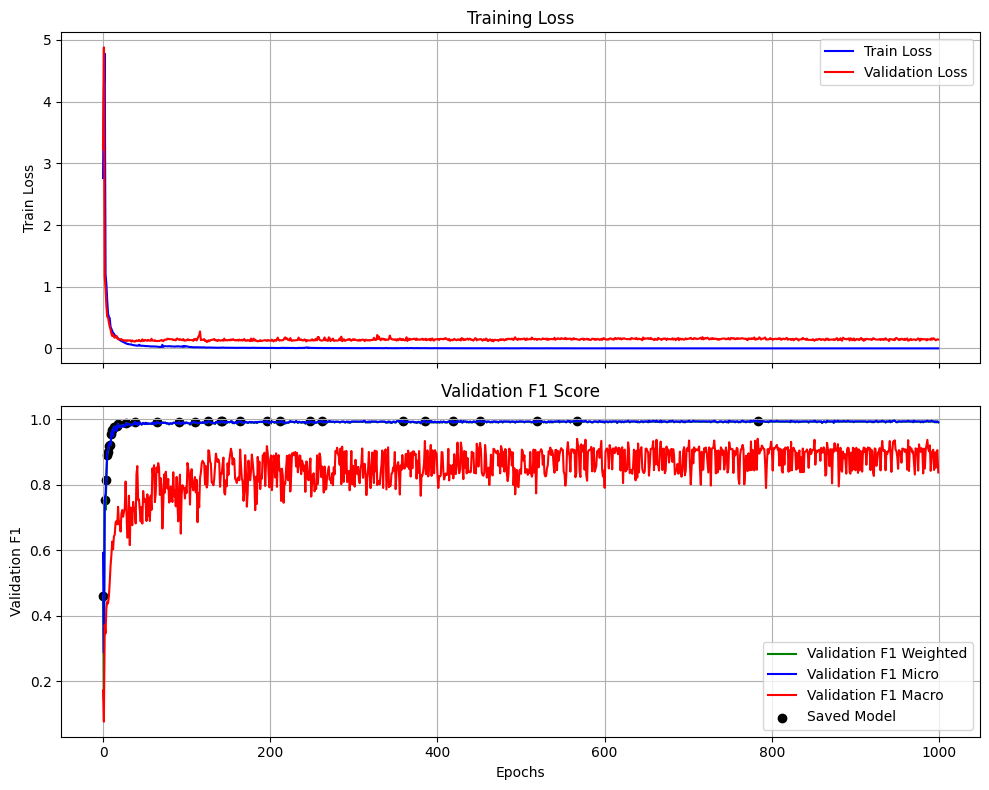

In [ ]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [ ]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path, weights_only=True))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, labels=range(len(class_map)))
    print(report)

print("Number of test graphs: ", len(test_graph_dataset))
eval(test_graph_dataset)


Number of test graphs:  589
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Evaluation:   0%|          | 0/589 [00:00<?, ?it/s]

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.9901
class_map ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack - Brute Force' 'Web Attack - Sql Injection'
 'Web Attack - XSS']
[[33358    12     2     1    47     1     1     9     0     1     9     6
      4    12     7]
 [    6   350     0     0     0     0     0     0     0     0     2     0
      0     0    11]
 [    0     0 22730     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0     0  1626     0     0     0     0     0     0     0     0
      0     0     0]
 [  184     0     0     0 32892     0     0     0     0     0     0     0
      0     0     0]
 [  304     0     0     0     0    63     0     0     0     0     0     0
      0     0     0]
 [  248     0     0     0     0   200   886     0     0     0     0     0
      0     0     0]
 [    4     0     0     0     0     0     0  1207     0     0     0     

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    global inject_edge_attr_pool_saved
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).view(-1)
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        # raise ValueError("No attacker nodes found.")
        return graph

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).view(-1)
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).view(-1)
        inject_edge_attr_pool = edge_attr[benign_edges]
        

    if len(inject_edge_attr_pool) == 0:
        if len(inject_edge_attr_pool_saved) > 0:
            inject_edge_attr_pool = th.cat(inject_edge_attr_pool_saved)
        else:
            return graph  # No edges to inject, return original graph
    else:
        inject_edge_attr_pool_saved.append(inject_edge_attr_pool)  # Save the pool for future use

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [ ]:
# Inject Attack Traffic to Attacker Nodes
inject_edge_attr_pool_saved = []
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=True) for g in test_graph_dataset]
print(len(th.cat(inject_edge_attr_pool_saved)))
eval(injected_graph_dataset, adversarial=True)

84330
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.4475
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0  

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

In [ ]:
# Inject BENIGN Traffic to Attacker Nodes
inject_edge_attr_pool_saved = []
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=False) for g in test_graph_dataset]
print(len(th.cat(inject_edge_attr_pool_saved)))
eval(injected_graph_dataset, adversarial=True)

7670
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.4203
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0  

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

In [ ]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [ ]:
# Inject Random Nodes in the graph
injected_graph_dataset = [inject_random_nodes(g.cpu(), 0.1, num_injected_nodes=1) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.4489
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0  

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [ ]:
def inject_random_edges(graph, ratio=0.1):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Inject new edges
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    for _ in range(num_to_inject):
        src = random.randint(0, x.size(0) - 1)  # from existing nodes
        dst = random.randint(0, x.size(0) - 1)  # to existing nodes

        if src != dst:  # Avoid self-loops
            new_edges.append([src, dst])
            attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
            new_attrs.append(attr)
            new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

    # 2. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        edge_index = th.cat([edge_index, new_edges], dim=1)
        edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        edge_label = th.cat([edge_label, new_labels], dim=0)

        # Create a new graph with the injected edges
        new_graph = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            edge_label=edge_label,
            x=x
        )

        return new_graph

    return graph  # No edges injected, return original graph

In [ ]:
# Inject Random Edges in the graph
injected_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/split_random_window_raw_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.5658
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0  

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera